# How to Read and Explore HDF5 Files with Python
This tutorial uses snow cover fraction and snow albedo data from...

Start by importing libraries

In [11]:
import h5py
import matplotlib.pyplot as plt
from osgeo import gdal
import glob
import numpy as np
import xarray

import rioxarray 
from rioxarray._options import EXPORT_GRID_MAPPING, get_option
from rioxarray.crs import crs_from_user_input
from rioxarray.exceptions import(
    DimensionError,
    DimensionMissingCoordinateError,
    InvalidDimensionOrder,
    MissingCRS,
    MissingSpatialDimensionError,
    NoDataInBounds,
    OneDimensionalRaster,
    RioXarrayError,
    TooManyDimensions,
)

import rasterio
from rasterio.control import GroundControlPoint
from rasterio.crs import CRS

from pyproj import Transformer
import earthpy as et
from affine import Affine
import holoviews as hv

* [Method 1 - h5py](#h5py)
* [Combine all files with glob](#glob)
* [Method 2 - GDAL](#gdal)
* [Method 3 - Rasterio](#rasterio)
* [Method 4 - rioxarray](#rioxarray)
* [Add a CRS](#crs)
* [Misc](#misc)

## Method 1 - h5py <a class="anchor" id="h5py"></a>

In [2]:
sierra2014_albedo = h5py.File('data/albedo_data/SierraAlbedo2014.h5', 'r')
sierra2014_snow_frac = h5py.File('data/snow_fraction_data/Sierra2014.h5', 'r')

Call the file

In [27]:
sierra2014_albedo

<HDF5 file "SierraAlbedo2014.h5" (mode r)>

In [3]:
sierra2014_snow_frac

<HDF5 file "Sierra2014.h5" (mode r)>

In [ ]:
out_file = h5py.File(sierra2014_snow_frac, w)

In [4]:
sierra2014_snow_frac.visit(print)

Grid
Grid/MODIS_GRID_500m
Grid/MODIS_GRID_500m/dust
Grid/MODIS_GRID_500m/grain_size
Grid/MODIS_GRID_500m/raw_snow_fraction
Grid/MODIS_GRID_500m/snow_fraction


Get the type of file

In [29]:
type(sierra2014_albedo)

h5py._hl.files.File

In [30]:
list(sierra2014_albedo)

['Grid']

In [31]:
list(sierra2014_snow_frac)

['Grid']

In [32]:
# Display contents of file using "keys" 
list(sierra2014_albedo.keys())

['Grid']

In [33]:
list(sierra2014_snow_frac.keys())

['Grid']

In [34]:
# Assign a variable to contain the Grid object
dset_sierra2014_albedo = sierra2014_albedo['Grid']

In [35]:
# Figure out what fields are contained in the Grid object
dset_sierra2014_albedo.keys()

<KeysViewHDF5 ['MODIS_GRID_500m']>

In [41]:
dset_sierra2014_snow_frac = sierra2014_snow_frac['Grid']
dset_sierra2014_snow_frac.keys()

<KeysViewHDF5 ['MODIS_GRID_500m']>

In [49]:
# What metadata is available in "Grid"? Use keys again, this time applied to the attributes, to see
for att in dset_sierra2014_albedo.attrs.keys():
    # name of attribute
    print (att)
    # value of attribute
    print (dset_sierra2014_albedo.attrs[att])

angleunits
degrees
aspect
normal
falseeasting
[0.]
falsenorthing
[-4000000.]
geoid
[6.37813700e+06 8.18191908e-02]
maplatlimit
[-90.  90.]
maplonlimit
[-255.   15.]
mapparallels
[34.  40.5]
mapprojection
eqaconicstd
nparallels
[2.]
origin
[   0. -120.    0.]
scalefactor
[1.]
trimlat
[-90.  90.]
trimlon
[-135.  135.]


In [50]:
for att in dset_sierra2014_snow_frac.attrs.keys():
    # name of attribute
    print (att)
    # value of attribute
    print (dset_sierra2014_snow_frac.attrs[att])

angleunits
b'degrees'
aspect
b'normal'
falseeasting
[0.]
falsenorthing
[-4000000.]
geoid
[6.37813700e+06 8.18191908e-02]
maplatlimit
[-90.  90.]
maplonlimit
[-255.   15.]
mapparallels
[34.  40.5]
mapprojection
b'eqaconicstd'
nparallels
[2.]
origin
[   0. -120.    0.]
scalefactor
[1.]
trimlat
[-90.  90.]
trimlon
[-135.  135.]


In [56]:
# Store all the different datasets in individual objects so they can be manipulated separately
# (in this case there's only one so the loop isn't super necessary, but included for completeness)
for ds in dset_sierra2014_albedo['MODIS_GRID_500m'].keys():      
        print (ds)
        ds_albedo_data = dset_sierra2014_albedo['MODIS_GRID_500m'][ds] # returns HDF5 dataset object

albedo


In [58]:
ds_albedo_data.attrs.keys()

<KeysViewHDF5 ['divisor']>

In [59]:
for ds in dset_sierra2014_snow_frac['MODIS_GRID_500m'].keys():      
        print (ds)
        ds_snow_frac_data = dset_sierra2014_snow_frac['MODIS_GRID_500m'][ds] # returns HDF5 dataset object

dust
grain_size
raw_snow_fraction
snow_fraction


In [60]:
ds_snow_frac_data.attrs.keys()

<KeysViewHDF5 ['divisor']>

In [63]:
ds_albedo_data

<HDF5 dataset "albedo": shape (365, 1334, 1841), type "<u2">

In [62]:
ds_snow_frac_data

<HDF5 dataset "snow_fraction": shape (365, 1334, 1841), type "|u1">

In [64]:
# xxx
with h5py.File('data/snow_fraction_data/Sierra2019.h5', 'r') as sierra2019:
    ls = list(sierra2019.keys())
    print('List of datasets in this file: \n', ls)
    data = sierra2019.get('dataset1')
    dataset1 = np.array(data)
    print('Shape of dataset1: \n', dataset1.shape)

List of datasets in this file: 
 ['Grid']
Shape of dataset1: 
 ()


## Combine all files with glob <a class="anchor" id="glob"></a>

In [8]:
all_snow_fraction = glob.glob('data/snow_fraction_data/*.h5')
all_snow_fraction

['data/snow_fraction_data/Sierra2015.h5',
 'data/snow_fraction_data/Sierra2005.h5',
 'data/snow_fraction_data/Sierra2011.h5',
 'data/snow_fraction_data/Sierra2001.h5',
 'data/snow_fraction_data/Sierra2010.h5',
 'data/snow_fraction_data/Sierra2014.h5',
 'data/snow_fraction_data/Sierra2004.h5',
 'data/snow_fraction_data/Sierra2013.h5',
 'data/snow_fraction_data/Sierra2003.h5',
 'data/snow_fraction_data/Sierra2017.h5',
 'data/snow_fraction_data/Sierra2007.h5',
 'data/snow_fraction_data/Sierra2016.h5',
 'data/snow_fraction_data/Sierra2006.h5',
 'data/snow_fraction_data/Sierra2012.h5',
 'data/snow_fraction_data/Sierra2002.h5',
 'data/snow_fraction_data/Sierra2019.h5',
 'data/snow_fraction_data/Sierra2009.h5',
 'data/snow_fraction_data/Sierra2018.h5',
 'data/snow_fraction_data/Sierra2008.h5']

## Method 2 - GDAL <a class="anchor" id="gdal"></a>

In [15]:
#sierra2015_albedo = gdal.Open("data/albedo_data/SierraAlbedo2015.h5", gdal.GA_ReadOnly)
sierra2015_albedo = gdal.Open("data/albedo_data/SierraAlbedo2015.h5")

In [18]:
sierra2015_albedo.GetSubDatasets()

[]

Read the data as an array

In [12]:
sierra2015_albedo_array = sierra2015_albedo.ReadAsArray()

In [13]:
type(sierra2015_albedo_array)

numpy.ndarray

In [13]:
sierra2015_albedo_array[:10]

array([[[65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535]],

       [[65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535]],

       [[65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 655

Get the shape of the array

In [14]:
sierra2015_albedo_array.shape

(365, 1334, 1841)

Get the value from the 300th day and the 1000th pixel in the x direction and the 1500th pixel in the y direction

In [20]:
sierra2015_albedo_array[300][1000][1500]

65535

In [71]:
sierra2018 = gdal.Open('data/snow_fraction_data/Sierra2018.h5')
print(sierra2018.GetMetadata())

{'Grid_angleunits': 'degrees', 'Grid_aspect': 'normal', 'Grid_falseeasting': '0 ', 'Grid_falsenorthing': '-4000000 ', 'Grid_geoid': '6378137 0.0818191908426215 ', 'Grid_maplatlimit': '-90 90 ', 'Grid_maplonlimit': '-255 15 ', 'Grid_mapparallels': '34 40.5 ', 'Grid_mapprojection': 'eqaconicstd', 'Grid_MODIS_GRID_500m_dust_divisor': '10 ', 'Grid_MODIS_GRID_500m_grain_size_divisor': '1 ', 'Grid_MODIS_GRID_500m_raw_snow_fraction_divisor': '100 ', 'Grid_MODIS_GRID_500m_ReferencingMatrix': '0 500 -285750 -500 0 500250 ', 'Grid_MODIS_GRID_500m_snow_fraction_divisor': '100 ', 'Grid_nparallels': '2 ', 'Grid_origin': '0 -120 0 ', 'Grid_scalefactor': '1 ', 'Grid_trimlat': '-90 90 ', 'Grid_trimlon': '-135 135 ', 'ISOdates': '2017274 2017275 2017276 2017277 2017278 2017279 2017280 2017281 2017282 2017283 2017284 2017285 2017286 2017287 2017288 2017289 2017290 2017291 2017292 2017293 2017294 2017295 2017296 2017297 2017298 2017299 2017300 2017301 2017302 2017303 2017304 2017305 2017306 2017307 20173

In [103]:
metadata = sierra2018.GetMetadata()
metadata
## this looks like a dictionary. Try to index using dictionary notation

{'Grid_angleunits': 'degrees',
 'Grid_aspect': 'normal',
 'Grid_falseeasting': '0 ',
 'Grid_falsenorthing': '-4000000 ',
 'Grid_geoid': '6378137 0.0818191908426215 ',
 'Grid_maplatlimit': '-90 90 ',
 'Grid_maplonlimit': '-255 15 ',
 'Grid_mapparallels': '34 40.5 ',
 'Grid_mapprojection': 'eqaconicstd',
 'Grid_MODIS_GRID_500m_dust_divisor': '10 ',
 'Grid_MODIS_GRID_500m_grain_size_divisor': '1 ',
 'Grid_MODIS_GRID_500m_raw_snow_fraction_divisor': '100 ',
 'Grid_MODIS_GRID_500m_ReferencingMatrix': '0 500 -285750 -500 0 500250 ',
 'Grid_MODIS_GRID_500m_snow_fraction_divisor': '100 ',
 'Grid_nparallels': '2 ',
 'Grid_origin': '0 -120 0 ',
 'Grid_scalefactor': '1 ',
 'Grid_trimlat': '-90 90 ',
 'Grid_trimlon': '-135 135 ',
 'ISOdates': '2017274 2017275 2017276 2017277 2017278 2017279 2017280 2017281 2017282 2017283 2017284 2017285 2017286 2017287 2017288 2017289 2017290 2017291 2017292 2017293 2017294 2017295 2017296 2017297 2017298 2017299 2017300 2017301 2017302 2017303 2017304 2017305 20

In [104]:
metadata['Grid_angleunits']

'degrees'

In [106]:
ref_matrix = metadata['Grid_MODIS_GRID_500m_ReferencingMatrix']
ref_matrix
# use string functions to separate the individual components of the ref matrix

'0 500 -285750 -500 0 500250 '

In [107]:
# https://gis.stackexchange.com/questions/345691/using-python-gdal-to-reproject-an-hdf
sierra2018.GetSubDatasets()

[('HDF5:"data/snow_fraction_data/Sierra2018.h5"://Grid/MODIS_GRID_500m/dust',
  '[365x1334x1841] //Grid/MODIS_GRID_500m/dust (16-bit unsigned integer)'),
 ('HDF5:"data/snow_fraction_data/Sierra2018.h5"://Grid/MODIS_GRID_500m/grain_size',
  '[365x1334x1841] //Grid/MODIS_GRID_500m/grain_size (16-bit unsigned integer)'),
 ('HDF5:"data/snow_fraction_data/Sierra2018.h5"://Grid/MODIS_GRID_500m/raw_snow_fraction',
  '[365x1334x1841] //Grid/MODIS_GRID_500m/raw_snow_fraction (8-bit unsigned character)'),
 ('HDF5:"data/snow_fraction_data/Sierra2018.h5"://Grid/MODIS_GRID_500m/snow_fraction',
  '[365x1334x1841] //Grid/MODIS_GRID_500m/snow_fraction (8-bit unsigned character)')]

In [73]:
sierra2018_band = gdal.Open(sierra2018.GetSubDatasets()[0][0], gdal.GA_ReadOnly)
sierra2018_arr = sierra2018_band.ReadAsArray()  #now numpy array

In [74]:
sierra2018_arr.shape

(365, 1334, 1841)

## Method 3 - Rasterio <a class="anchor" id="rasterio"></a>

In [4]:
sierra2019 = rasterio.open('data/snow_fraction_data/Sierra2019.h5')

In [5]:
sierra2019

<open DatasetReader name='data/snow_fraction_data/Sierra2019.h5' mode='r'>

In [6]:
sierra2019.subdatasets

['HDF5:data/snow_fraction_data/Sierra2019.h5://Grid/MODIS_GRID_500m/dust',
 'HDF5:data/snow_fraction_data/Sierra2019.h5://Grid/MODIS_GRID_500m/grain_size',
 'HDF5:data/snow_fraction_data/Sierra2019.h5://Grid/MODIS_GRID_500m/raw_snow_fraction',
 'HDF5:data/snow_fraction_data/Sierra2019.h5://Grid/MODIS_GRID_500m/snow_fraction']

In [7]:
metadata_rasterio = sierra2019.tags()
metadata_rasterio

{'Grid_angleunits': 'degrees',
 'Grid_aspect': 'normal',
 'Grid_falseeasting': '0 ',
 'Grid_falsenorthing': '-4000000 ',
 'Grid_geoid': '6378137 0.0818191908426215 ',
 'Grid_maplatlimit': '-90 90 ',
 'Grid_maplonlimit': '-255 15 ',
 'Grid_mapparallels': '34 40.5 ',
 'Grid_mapprojection': 'eqaconicstd',
 'Grid_MODIS_GRID_500m_dust_divisor': '10 ',
 'Grid_MODIS_GRID_500m_grain_size_divisor': '1 ',
 'Grid_MODIS_GRID_500m_raw_snow_fraction_divisor': '100 ',
 'Grid_MODIS_GRID_500m_ReferencingMatrix': '0 500 -285750 -500 0 500250 ',
 'Grid_MODIS_GRID_500m_snow_fraction_divisor': '100 ',
 'Grid_nparallels': '2 ',
 'Grid_origin': '0 -120 0 ',
 'Grid_scalefactor': '1 ',
 'Grid_trimlat': '-90 90 ',
 'Grid_trimlon': '-135 135 ',
 'ISOdates': '2018274 2018275 2018276 2018277 2018278 2018279 2018280 2018281 2018282 2018283 2018284 2018285 2018286 2018287 2018288 2018289 2018290 2018291 2018292 2018293 2018294 2018295 2018296 2018297 2018298 2018299 2018300 2018301 2018302 2018303 2018304 2018305 20

In [115]:
grid_angleunits = metadata_rasterio['Grid_angleunits']
grid_angleunits

'degrees'

In [124]:
map_projection = metadata_rasterio['Grid_mapprojection']
map_projection

'eqaconicstd'

In [8]:
type(sierra2019)

rasterio.io.DatasetReader

In [70]:
sierra2019.shape
# that's weird

(512, 512)

AttributeError: 'DatasetReader' object has no attribute 'info'

## Method 4 - rioxarry <a class="anchor" id="rioxarray"></a>

In [2]:
sierra2016 = rioxarray.open_rasterio('data/snow_fraction_data/Sierra2016.h5')
sierra2016

/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rioxarray/_io.py:839: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rioxarray/_io.py:839: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.

<xarray.Dataset>
Dimensions:                                 (y: 1334, x: 1841, band: 366)
Coordinates:
  * y                                       (y) float64 0.5 1.5 ... 1.334e+03
  * x                                       (x) float64 0.5 1.5 ... 1.84e+03
  * band                                    (band) int64 1 2 3 4 ... 364 365 366
    spatial_ref                             int64 0
Data variables:
    Grid_MODIS_GRID_500m_dust               (band, y, x) uint16 ...
    Grid_MODIS_GRID_500m_grain_size         (band, y, x) uint16 ...
    Grid_MODIS_GRID_500m_raw_snow_fraction  (band, y, x) uint8 ...
    Grid_MODIS_GRID_500m_snow_fraction      (band, y, x) uint8 ...
Attributes: (12/21)
    Grid_angleunits:                                 degrees
    Grid_aspect:                                     normal
    Grid_falseeasting:                               0
    Grid_falsenorthing:                              -4000000
    Grid_geoid:                                      6378137 0.0818191908426215 
    Grid_maplatlimit:                                -90 90 
    ...                                              ...
    Grid_origin:                                     0 -120 0 
    Grid_scalefactor:                                1
    Grid_trimlat:                                    -90 90 
    Grid_trimlon:                                    -135 135 
    ISOdates:                                        2015274 2015275 2015276 ...
    MATLABdates:                                     736238 736239 736240 736...

In [25]:
type(sierra2016)

xarray.core.dataset.Dataset

In [14]:
sierra2016.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                                 (y: 1334, x: 1841, band: 366)
Coordinates:
  * y                                       (y) float64 0.5 1.5 ... 1.334e+03
  * x                                       (x) float64 0.5 1.5 ... 1.84e+03
  * band                                    (band) int64 1 2 3 4 ... 364 365 366
    spatial_ref                             int64 0
Data variables:
    Grid_MODIS_GRID_500m_dust               (band, y, x) uint16 ...
    Grid_MODIS_GRID_500m_grain_size         (band, y, x) uint16 ...
    Grid_MODIS_GRID_500m_raw_snow_fraction  (band, y, x) uint8 ...
    Grid_MODIS_GRID_500m_snow_fraction      (band, y, x) uint8 ...
Attributes: (12/21)
    Grid_angleunits:                                 degrees
    Grid_aspect:                                     normal
    Grid_falseeasting:                               0
    Grid_falsenorthing:                              -4000000
    Grid_geoid:                   

In [19]:
sierra2016.band

<xarray.DataArray 'band' (band: 366)>
array([  1,   2,   3, ..., 364, 365, 366])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

In [17]:
# get the variables that are in the dataset
sierra2016.data_vars

Data variables:
    Grid_MODIS_GRID_500m_dust               (band, y, x) uint16 ...
    Grid_MODIS_GRID_500m_grain_size         (band, y, x) uint16 ...
    Grid_MODIS_GRID_500m_raw_snow_fraction  (band, y, x) uint8 ...
    Grid_MODIS_GRID_500m_snow_fraction      (band, y, x) uint8 ...

In [20]:
# select one variable and pick the first entry along the first axis (day 1)
sierra2016.Grid_MODIS_GRID_500m_snow_fraction[0]

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (y: 1334, x: 1841)>
[2455894 values with dtype=uint8]
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
    band         int64 1
    spatial_ref  int64 0
Attributes:
    Grid_MODIS_GRID_500m_snow_fraction_divisor:  100
    scale_factor:                                1.0
    add_offset:                                  0.0

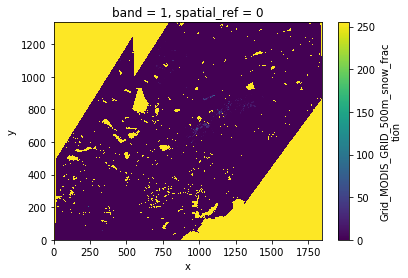

In [3]:
# Plot one timestep (first day)
sierra2016.Grid_MODIS_GRID_500m_snow_fraction[0].plot()

(<matplotlib.collections.QuadMesh at 0x7fa10029b9d0>,
 xarray.core.dataset.Dataset)

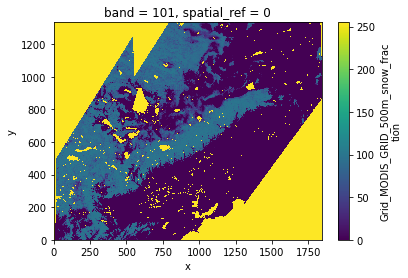

In [4]:
# Plot one timestep (101th day)
# xxx need to transpose x and y
# plotted values don't utilize the divisor
sierra2016.Grid_MODIS_GRID_500m_snow_fraction[100].plot(), type(sierra2016)

In [26]:
# dataset dimensions
sierra2016.dims

Frozen({'y': 1334, 'x': 1841, 'band': 366})

In [24]:
# dataset coordinates
sierra2016.coords

Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

In [25]:
# dataset global attributes
sierra2016.attrs

{'Grid_angleunits': 'degrees',
 'Grid_aspect': 'normal',
 'Grid_falseeasting': 0,
 'Grid_falsenorthing': -4000000,
 'Grid_geoid': '6378137 0.0818191908426215 ',
 'Grid_maplatlimit': '-90 90 ',
 'Grid_maplonlimit': '-255 15 ',
 'Grid_mapparallels': '34 40.5 ',
 'Grid_mapprojection': 'eqaconicstd',
 'Grid_MODIS_GRID_500m_dust_divisor': 10,
 'Grid_MODIS_GRID_500m_grain_size_divisor': 1,
 'Grid_MODIS_GRID_500m_raw_snow_fraction_divisor': 100,
 'Grid_MODIS_GRID_500m_ReferencingMatrix': '0 500 -285750 -500 0 500250 ',
 'Grid_MODIS_GRID_500m_snow_fraction_divisor': 100,
 'Grid_nparallels': 2,
 'Grid_origin': '0 -120 0 ',
 'Grid_scalefactor': 1,
 'Grid_trimlat': '-90 90 ',
 'Grid_trimlon': '-135 135 ',
 'ISOdates': '2015274 2015275 2015276 2015277 2015278 2015279 2015280 2015281 2015282 2015283 2015284 2015285 2015286 2015287 2015288 2015289 2015290 2015291 2015292 2015293 2015294 2015295 2015296 2015297 2015298 2015299 2015300 2015301 2015302 2015303 2015304 2015305 2015306 2015307 2015308 20

In [5]:
# Extract the snow fraction variable/datarray
sierra2016["Grid_MODIS_GRID_500m_snow_fraction"]  # Equivalent to sierra2016.Grid_MODIS_GRID_500m_snow_fraction

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (band: 366, y: 1334,
                                                        x: 1841)>
[898857204 values with dtype=uint8]
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0
Attributes:
    Grid_MODIS_GRID_500m_snow_fraction_divisor:  100
    scale_factor:                                1.0
    add_offset:                                  0.0

In [6]:
# The actual (numpy) array data
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.data

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [28]:
sierra2016_sf = sierra2016.Grid_MODIS_GRID_500m_snow_fraction.data
sierra2016_sf

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [31]:
type(sierra2016_sf), sierra2016_sf.shape

(numpy.ndarray, (366, 1334, 1841))

In [41]:
sierra2016.dims

Frozen({'y': 1334, 'x': 1841, 'band': 366})

In [32]:
# dataarray/variable dimensions
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.dims

('band', 'y', 'x')

In [44]:
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.band

<xarray.DataArray 'band' (band: 366)>
array([  1,   2,   3, ..., 364, 365, 366])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

In [45]:
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.y

<xarray.DataArray 'y' (y: 1334)>
array([5.0000e-01, 1.5000e+00, 2.5000e+00, ..., 1.3315e+03, 1.3325e+03,
       1.3335e+03])
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
    spatial_ref  int64 0

In [52]:
x_values = sierra2016.Grid_MODIS_GRID_500m_snow_fraction.x
x_values[10:]

<xarray.DataArray 'x' (x: 1831)>
array([  10.5,   11.5,   12.5, ..., 1838.5, 1839.5, 1840.5])
Coordinates:
  * x            (x) float64 10.5 11.5 12.5 13.5 ... 1.838e+03 1.84e+03 1.84e+03
    spatial_ref  int64 0

In [33]:
# datarray/variable coordinates
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.coords

Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

In [56]:
sierra2016.coords["band"]

<xarray.DataArray 'band' (band: 366)>
array([  1,   2,   3, ..., 364, 365, 366])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

In [57]:
sierra2016.coords["x"]

<xarray.DataArray 'x' (x: 1841)>
array([5.0000e-01, 1.5000e+00, 2.5000e+00, ..., 1.8385e+03, 1.8395e+03,
       1.8405e+03])
Coordinates:
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
    spatial_ref  int64 0

In [58]:
sierra2016.coords["y"]

<xarray.DataArray 'y' (y: 1334)>
array([5.0000e-01, 1.5000e+00, 2.5000e+00, ..., 1.3315e+03, 1.3325e+03,
       1.3335e+03])
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
    spatial_ref  int64 0

In [7]:
# dataarray/variable attributes
sf_2016 = sierra2016.Grid_MODIS_GRID_500m_snow_fraction.data
sf_2016 # numpy array

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [69]:
sf_2016_att  = sierra2016.Grid_MODIS_GRID_500m_snow_fraction.attrs
sf_2016_att

{'Grid_MODIS_GRID_500m_snow_fraction_divisor': 100,
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'my_custom_attribute': 'Foo Bar'}

In [70]:
type(sf_2016_att)

dict

In [75]:
type(sf_2016), sf_2016.shape

(numpy.ndarray, (366, 1334, 1841))

In [8]:
# dataarray/variable attributes
sf_2016_array = sierra2016['Grid_MODIS_GRID_500m_snow_fraction']
sf_2016_array # xarray

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (band: 366, y: 1334,
                                                        x: 1841)>
array([[[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]],

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]],

       ...,

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]],

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]]], dtype=uint8)
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0
Attributes:
    Grid_MODIS_GRID_500m_snow_fraction_divisor:  100
    scale_factor:                                1.0
    add_offset:                                  0.0

In [84]:
type(sf_2016_array) # depending on how you create the dataframe you get a numpy array or and xarray

xarray.core.dataarray.DataArray

In [9]:
sf_2016_array.shape

(366, 1334, 1841)

In [40]:
sf_divisor = sf_2016['Grid_MODIS_GRID_500m_snow_fraction_divisor']
sf_divisor

100

In [59]:
# Set some new arbitray attribute on a data variable/datarray
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.attrs["my_custom_attribute"] = "Foo Bar"
sierra2016.Grid_MODIS_GRID_500m_snow_fraction.attrs

{'Grid_MODIS_GRID_500m_snow_fraction_divisor': 100,
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'my_custom_attribute': 'Foo Bar'}

In [61]:
ex_data = np.random.random(size=1000).reshape(10, 100)
ex_data.shape

(10, 100)

In [64]:
ex_arr = xarray.DataArray(ex_data, dims=['x', 'y'], coords={'x': np.arange(10, 20), 'y': np.arange(100)})
ex_arr

<xarray.DataArray (x: 10, y: 100)>
array([[5.46562014e-01, 5.28251424e-01, 8.14150897e-01, 2.38337258e-01,
        2.78526227e-01, 6.01497594e-01, 8.22731720e-01, 4.70316205e-03,
        9.81887517e-02, 2.60530563e-02, 1.65972830e-02, 9.43967541e-01,
        2.37655136e-01, 1.29077432e-01, 6.67559804e-01, 6.50469210e-01,
        8.53794844e-01, 3.14044375e-01, 7.20466811e-01, 1.59321574e-01,
        7.95617271e-01, 9.11599801e-01, 6.49392148e-01, 7.42235198e-01,
        4.08527241e-01, 2.22139739e-02, 7.34904151e-01, 7.90233044e-01,
        2.22163082e-01, 6.72409731e-01, 3.82041429e-01, 2.97824095e-01,
        9.25488561e-01, 9.52414237e-01, 3.91111087e-01, 7.33292720e-01,
        2.05611871e-01, 4.35989907e-01, 4.73689358e-02, 8.42935446e-01,
        3.92013067e-01, 8.72642325e-01, 7.77100368e-01, 5.79330084e-01,
        5.59645948e-01, 2.36754838e-01, 2.39309132e-02, 5.53712867e-01,
        8.53474925e-01, 5.37556294e-02, 6.11146718e-01, 6.39090793e-01,
        2.30365793e-01, 3.73209807e-01, 5.73365435e-01, 3.75427082e-01,
        8.82830160e-01, 7.86591500e-01, 4.90418882e-01, 5.02603598e-01,
        1.69827938e-01, 1.92702332e-01, 5.45920810e-01, 9.91430388e-01,
        2.27684110e-01, 9.19569588e-01, 1.66111537e-01, 4.12909298e-01,
        9.88428861e-01, 5.13051154e-01, 8.74499234e-01, 5.34475094e-01,
        8.14162646e-01, 8.77233881e-01, 7.61423836e-01, 8.50888464e-01,
        5.49462485e-01, 1.76917957e-01, 2.82955957e-01, 6.85144491e-01,
...
        7.40292662e-01, 8.64141247e-01, 6.58679149e-02, 9.10671863e-01,
        6.99472462e-01, 9.45105182e-01, 5.35130104e-02, 5.56232363e-01,
        8.51495755e-01, 3.15952654e-01, 5.00447423e-02, 6.59357505e-01,
        9.69000593e-03, 2.57405286e-01, 5.86658732e-01, 7.70205625e-02,
        9.89012473e-02, 5.50492004e-01, 8.56765735e-01, 8.27829965e-01,
        1.50971942e-01, 9.35194183e-01, 6.03872514e-01, 4.76872234e-01,
        8.32791433e-01, 9.02623436e-02, 3.72452636e-01, 6.53813988e-01,
        5.51572567e-01, 4.02127133e-01, 9.49219586e-01, 2.05901091e-01,
        1.67152363e-01, 5.81634853e-01, 2.62854803e-01, 8.30002892e-01,
        6.77499648e-01, 4.28452211e-01, 2.43426761e-01, 5.64669099e-01,
        4.28028352e-01, 6.89769936e-01, 5.80535509e-01, 4.62127053e-01,
        7.74935298e-01, 1.72187678e-01, 3.82698263e-01, 8.92551068e-01,
        1.72106678e-01, 1.24233118e-01, 5.06026899e-01, 6.52031494e-01,
        3.72816771e-02, 4.32565961e-01, 6.93403568e-02, 7.49685360e-01,
        2.39101884e-01, 7.51299151e-01, 7.78621022e-01, 7.07295240e-01,
        6.77813957e-01, 1.43445080e-01, 7.99442255e-01, 4.16811885e-01,
        1.95482954e-01, 1.48964752e-01, 5.41729618e-01, 6.59612627e-01,
        3.58492645e-01, 5.41956504e-01, 6.16143092e-01, 9.27707847e-01,
        4.70494471e-01, 1.51214844e-01, 7.04384130e-01, 2.29366575e-01,
        6.55663619e-01, 1.80141215e-01, 2.93417366e-01, 9.51610751e-01]])
Coordinates:
  * x        (x) int64 10 11 12 13 14 15 16 17 18 19
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99

## Indexing with Xarray

In [77]:
# extract a time-series for one spatial location
sf_2016[:, 20, 40] # with numpy

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 11, 16, 22,
       28, 33, 38, 42, 45, 47, 49, 50, 50, 51, 51, 51, 59, 65, 72, 78, 84,
       89, 90, 88, 82, 75, 64, 54, 45, 38, 32, 32, 32, 32, 32, 33, 35, 36,
       37, 37, 36, 34, 30, 26, 22, 19, 17, 17, 17, 18, 17, 16, 10, 10, 10,
       10, 10, 10, 10, 10,  9, 15, 16, 15, 14, 12, 11, 10, 10, 10,  9,  8,
        2,  2,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [79]:
# extract a time-series for one spatial location with numpy array
sf_2016[:, 1000, 450]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   8,  14,  19,  25,  29,  32,  33,  33,  31,
        29,  27,  24,  22,  20,  19,  18,  17,  16,  14,  12,  11,  16,
        22,  28,  35,  42,  46,  46,  45,  41,  37,  33,  30,  28,  27,
        27,  28,  31,  35,  40,  46,  52,  58,  64,  71,  76,  81,  84,
        87,  89,  91,  92,  93,  95,  96,  97,  98,  99, 100, 100, 100,
       100, 100, 100, 100,  99,  99,  99,  99,  98,  98,  98,  97,  98,
        97,  98,  97,  98,  97,  97,  96,  96,  95,  94,  92,  92,  91,
        92,  92,  93,  94,  95,  96,  96,  96,  94,  92,  88,  84,  79,
        74,  70,  64,  59,  54,  49,  46,  42,  40,  38,  35,  34,  32,
        31,  31,  30,  30,  29,  28,  24,  24,  24,  23,  21,  19,  17,
        14,  12,  10,   8,   6,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   7,   9,  10,  10,   8,   7,   6,   0,   0,   

In [85]:
# extract a time-series for one spatial location with xarray
# numpy style indexing still works but preserve the labels/metadata
sf_2016_array[:, 1000, 450] # y=1000, x=450

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (band: 366)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Coordinates:
    y            float64 1e+03
    x            float64 450.5
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0
Attributes:
    Grid_MODIS_GRID_500m_snow_fraction_divisor:  100
    scale_factor:                                1.0
    add_offset:                                  0.0
    my_custom_attribute:                         Foo Bar

### Positional indexing wtih dimension names
'isel' = selecting by index
'sel' = selecting by actual values (example: da.sel(lat=-32, lon=60.plot()

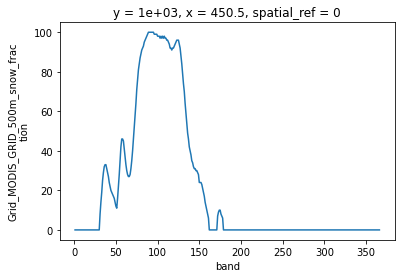

In [10]:
sf_2016_array.isel(y=1000, x=450).plot()

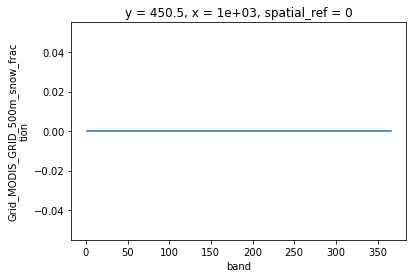

In [89]:
sf_2016_array.isel(y=450, x=1000).plot()

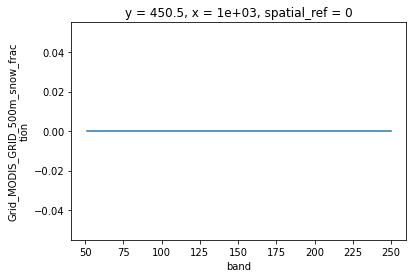

In [93]:
# slicing
sf_2016_array.isel(band=slice(50, 250), y=450, x=1000).plot()

In [100]:
# divide all values by a number
# sf_2016_array / 100
sf_2016_array / sf_divisor

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (band: 366, y: 1334,
                                                        x: 1841)>
array([[[2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        ...,
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55]],

       [[2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        ...,
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55]],

       [[2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        ...,
...
        ...,
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55]],

       [[2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        ...,
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55]],

       [[2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        ...,
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55],
        [2.55, 2.55, 2.55, ..., 2.55, 2.55, 2.55]]])
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

### Aggregation (Reduction) Methods
Xarray supports many of the aggregations methods that numpy has. A partial list includes: all, any, argmax, argmin, max, mean, median, min, prod, sum, std, var.

Whereas the numpy syntax would require scalar axes, xarray can use dimension names:

In [120]:
# annual average for each pixel
sf_2016_mean_df = sf_2016_array.mean(dim="band")
sf_2016_mean_df

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (y: 1334, x: 1841)>
array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
    spatial_ref  int64 0

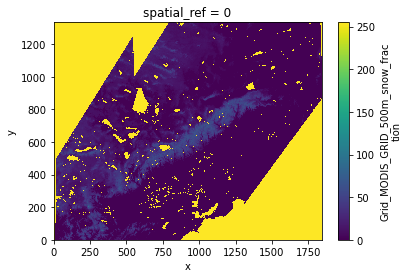

In [121]:
sf_2016_mean = sf_2016_array.mean(dim="band").plot()

In [105]:
ex_month = sf_2016_array.isel(band=slice(100, 130))
ex_month

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (band: 30, y: 1334,
                                                        x: 1841)>
array([[[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]],

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]],

       ...,

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]],

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]]], dtype=uint8)
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 101 102 103 104 105 106 ... 126 127 128 129 130
    spatial_ref  int64 0
Attributes:
    Grid_MODIS_GRID_500m_snow_fraction_divisor:  100
    scale_factor:                                1.0
    add_offset:                                  0.0
    my_custom_attribute:                         Foo Bar

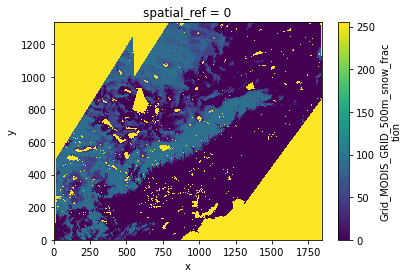

In [107]:
ex_monthly_mean = ex_month.mean(dim="band").plot()

In [108]:
ex_monthly_mean_df = ex_month.mean(dim="band")
ex_monthly_mean_df

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (y: 1334, x: 1841)>
array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
    spatial_ref  int64 0

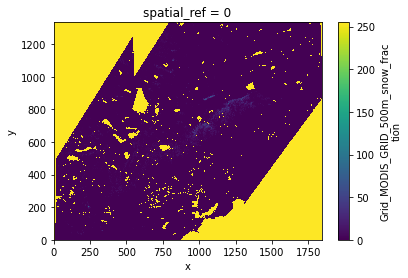

In [132]:
# xxx...check if the range includes the 30 or not
october_2016 = sf_2016_array.isel(band=slice(0, 30))
october_2016.mean(dim="band").plot()

In [133]:
october_2016.shape

(30, 1334, 1841)

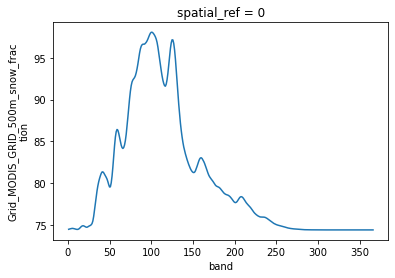

In [130]:
# mean for all pixels over year
sf_2016_array.mean(dim=["y", "x"]).plot()

### Broadcasting

In [117]:
sf_2016_array.shape, sf_2016_array.dims

((366, 1334, 1841), ('band', 'y', 'x'))

In [122]:
sf_2016_mean_df.shape, sf_2016_mean_df.dims

((1334, 1841), ('y', 'x'))

In [125]:
# Subtract the mean (2D array) from the original array (3D array)
sf_anom = sf_2016_array - sf_2016_mean_df
sf_anom
# anomaly from 2016 average

<xarray.DataArray 'Grid_MODIS_GRID_500m_snow_fraction' (band: 366, y: 1334,
                                                        x: 1841)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.332e+03 1.332e+03 1.334e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.838e+03 1.84e+03 1.84e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    spatial_ref  int64 0

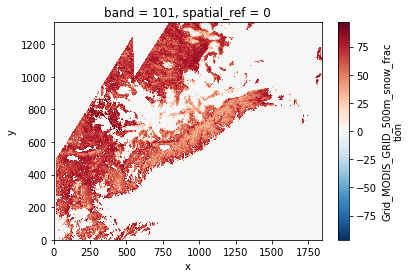

In [126]:
# how day 101 compares to the annual mean
sf_anom[100].plot()

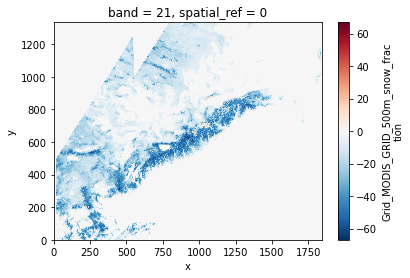

In [127]:
# how day 101 compares to the annual mean
sf_anom[20].plot()

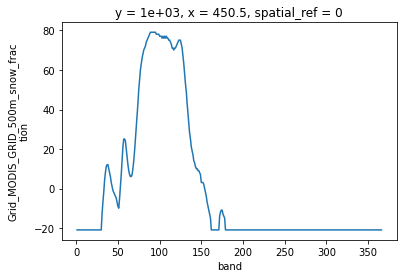

In [128]:
sf_anom.isel(y=1000, x=450).plot()

In [33]:
sierra2016_sf.xarray.transpose

AttributeError: 'numpy.ndarray' object has no attribute 'xarray'

## Add a CRS <a class="anchor" id="crs"></a>

In [79]:
sierra2017 = rioxarray.open_rasterio('data/snow_fraction_data/Sierra2018.h5',
                                    variable=["0"],
                                    parse_coordinates=False,)

In [84]:
# This shows that the file does not currently have a crs
print("The CRS of this data is:", sierra2017.rio.crs)

The CRS of this data is: None


In [85]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/raster-metadata-in-python/
a_crs = sierra2017.rio.crs
# assign crs to object
sierra2017 = sierra2017.rio.set_crs(a_crs, inplace=True)

CRSError: Invalid projection: : (Internal Proj Error: proj_create: unrecognized format / unknown name)

In [86]:
print(list(et.epsg.keys())[:10])

['29188', '26733', '24600', '32189', '4899', '29189', '26734', '7402', '26951', '29190']


In [87]:
proj4 = et.epsg['3310']
print(proj4)

+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +datum=NAD83 +units=m +no_defs


In [88]:
sierra2017 = sierra2017.rio.set_crs(proj4, inplace=True)
print("The CRS of this data is:", sierra2017.rio.crs)

The CRS of this data is: EPSG:3310


In [89]:
sierra2017.rio.crs

CRS.from_epsg(3310)

'+proj=aea' is the projection, in this case aea = Albers Equal Area

units=m means that the units are meters

In [90]:
type(sierra2017)

xarray.core.dataset.Dataset

In [ ]:
transformer = Transformer.from_crs("EPSG:4326", crs_str, always_xy=True)
west, north = transformer.transform(rds.WESTBOUNDINGCOORDINATE, rds.NORTHBOUNDINGCOORDINATE)

## Misc <a class="anchor" id="misc"></a>

In [11]:
xarray_example = xarray.open_dataset('data/snow_fraction_data/Sierra2016.h5', engine='rasterio')
xarray_example

/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/marierivers/opt/anaconda3/envs/eds223/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be re

<xarray.Dataset>
Dimensions:                                 (y: 1334, x: 1841, band: 366)
Coordinates:
  * y                                       (y) float64 0.5 1.5 ... 1.334e+03
  * x                                       (x) float64 0.5 1.5 ... 1.84e+03
  * band                                    (band) int64 1 2 3 4 ... 364 365 366
    spatial_ref                             int64 ...
Data variables:
    Grid_MODIS_GRID_500m_dust               (band, y, x) float32 ...
    Grid_MODIS_GRID_500m_grain_size         (band, y, x) float32 ...
    Grid_MODIS_GRID_500m_raw_snow_fraction  (band, y, x) float32 ...
    Grid_MODIS_GRID_500m_snow_fraction      (band, y, x) float32 ...
Attributes: (12/21)
    Grid_angleunits:                                 degrees
    Grid_aspect:                                     normal
    Grid_falseeasting:                               0
    Grid_falsenorthing:                              -4000000
    Grid_geoid:                                      6378137 0.0818191908426215 
    Grid_maplatlimit:                                -90 90 
    ...                                              ...
    Grid_origin:                                     0 -120 0 
    Grid_scalefactor:                                1
    Grid_trimlat:                                    -90 90 
    Grid_trimlon:                                    -135 135 
    ISOdates:                                        2015274 2015275 2015276 ...
    MATLABdates:                                     736238 736239 736240 736...

In [ ]:
xarray_example.info